
#**Suryakanta Karan (M22AIE207) m22aie207@iitj.ac.in**

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/surya/DL_Ops/Assignment_2')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Load USPS dataset
transform = transforms.Compose([transforms.Resize((28, 28)),  # Resize images to 28x28
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.USPS(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.USPS(root='./data', train=False, transform=transform, download=True)

100%|██████████| 6579383/6579383 [00:01<00:00, 3831644.98it/s]


100%|██████████| 1831726/1831726 [00:01<00:00, 1380498.35it/s]


In [4]:
# Define data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [5]:
# Initialize models
input_size = 28 * 28
hidden_size = 256
num_classes = 10

mlp_model = MLP(input_size, hidden_size, num_classes)
cnn_model = CNN(num_classes)

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training function for MLP
def train_mlp(epoch):
    mlp_model.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.reshape(-1, 28*28)
        mlp_optimizer.zero_grad()
        outputs = mlp_model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        mlp_optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print('[Epoch: %d, Batch: %5d] Loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 100))
            running_loss = 0.0
    return running_loss / len(train_loader)  # Return average loss for the epoch

# Training function for CNN
def train_cnn(epoch):
    cnn_model.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        cnn_optimizer.zero_grad()
        outputs = cnn_model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        cnn_optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print('[Epoch: %d, Batch: %5d] Loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 100))
            running_loss = 0.0

In [7]:
# Evaluation function
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data, labels in test_loader:
            if isinstance(model, MLP):
                data = data.reshape(-1, 28*28)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    accuracy = 100 * correct / total
    confusion_mat = confusion_matrix(all_labels, all_predictions)
    return accuracy, confusion_mat

In [8]:
# Training and evaluating MLP
writer = SummaryWriter()
for epoch in range(10):
    loss = train_mlp(epoch)  # Capture loss value returned by train_mlp
    accuracy, confusion_mat = evaluate(mlp_model)
    writer.add_scalar('MLP/Loss', loss, epoch)  # Use captured loss value
    writer.add_scalar('MLP/Accuracy', accuracy, epoch)
    print('MLP Accuracy on test set after epoch {}: {}%'.format(epoch+1, accuracy))
    print('Confusion Matrix:\n', confusion_mat)

[Epoch: 1, Batch:   100] Loss: 0.444
MLP Accuracy on test set after epoch 1: 90.68261086198306%
Confusion Matrix:
 [[348   0   0   3   3   0   3   0   1   1]
 [  0 254   0   3   2   0   5   0   0   0]
 [  3   0 171   5   9   2   3   2   3   0]
 [  1   0   5 145   2  12   0   0   0   1]
 [  1   2   5   0 180   0   4   1   0   7]
 [  3   0   1   8   3 142   1   0   0   2]
 [  2   0   3   0   3   2 160   0   0   0]
 [  0   1   0   2   5   2   0 132   0   5]
 [  3   2   6   8   7  10   2   1 125   2]
 [  0   2   1   0   6   1   0   3   1 163]]
[Epoch: 2, Batch:   100] Loss: 0.177
MLP Accuracy on test set after epoch 2: 91.6791230692576%
Confusion Matrix:
 [[344   0   1   2   3   1   7   0   0   1]
 [  0 251   0   3   3   0   5   0   0   2]
 [  2   0 171   3  11   2   1   1   6   1]
 [  2   0   3 140   1  15   0   1   3   1]
 [  2   1   2   0 179   1   2   1   0  12]
 [  2   0   0   5   3 146   0   0   0   4]
 [  0   0   3   0   3   1 163   0   0   0]
 [  0   0   0   3   3   1   0 132   1  

In [9]:
# Training and evaluating CNN
for epoch in range(10):
    train_cnn(epoch)
    accuracy, confusion_mat = evaluate(cnn_model)
    writer.add_scalar('CNN/Loss', loss, epoch)  # Corrected line
    writer.add_scalar('CNN/Accuracy', accuracy, epoch)
    print('CNN Accuracy on test set after epoch {}: {}%'.format(epoch+1, accuracy))
    print('Confusion Matrix:\n', confusion_mat)

[Epoch: 1, Batch:   100] Loss: 0.746
CNN Accuracy on test set after epoch 1: 89.73592426507224%
Confusion Matrix:
 [[346   0   6   1   3   0   1   0   1   1]
 [  0 251   3   3   2   0   3   1   1   0]
 [  5   0 177   2   9   1   0   1   3   0]
 [  2   0   9 145   2   6   0   0   1   1]
 [  3   2  10   0 175   0   1   1   1   7]
 [ 11   0   6  10   4 125   0   1   1   2]
 [  3   0   5   0   3   1 158   0   0   0]
 [  0   0   3   1   4   0   0 130   1   8]
 [  7   1   7   4   3   2   0   3 137   2]
 [  0   2   1   1   5   0   0  10   1 157]]
[Epoch: 2, Batch:   100] Loss: 0.203
CNN Accuracy on test set after epoch 2: 92.07772795216741%
Confusion Matrix:
 [[341   1   4   3   3   2   3   0   1   1]
 [  0 257   0   3   0   0   4   0   0   0]
 [  1   1 175  10   4   2   1   1   3   0]
 [  0   0   3 151   1   8   0   1   1   1]
 [  1   2   4   0 174   2   2   1   0  14]
 [  2   1   0   6   2 144   0   1   0   4]
 [  1   0   3   0   2   2 160   0   2   0]
 [  0   0   0   2   4   0   0 132   0 

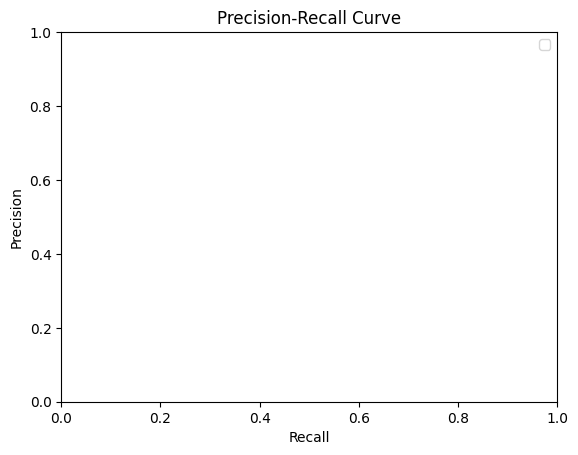

In [10]:
# Precision-Recall curve
def plot_precision_recall_curve():
    mlp_model.eval()
    cnn_model.eval()
    all_labels = []
    all_probs_mlp = []
    all_probs_cnn = []
    with torch.no_grad():
        for data, labels in test_loader:
            data_mlp = data.reshape(-1, 28*28)
            outputs_mlp = mlp_model(data_mlp)
            outputs_cnn = cnn_model(data)
            probs_mlp = nn.functional.softmax(outputs_mlp, dim=1).numpy()
            probs_cnn = nn.functional.softmax(outputs_cnn, dim=1).numpy()
            all_labels.extend(labels.numpy())
            all_probs_mlp.extend(probs_mlp)
            all_probs_cnn.extend(probs_cnn)

    all_probs_mlp = np.array(all_probs_mlp)
    all_probs_cnn = np.array(all_probs_cnn)

    # Calculate precision-recall curve for MLP
    precision_mlp = dict()
    recall_mlp = dict()
    for i in range(num_classes):
        if np.sum(all_labels == i) > 0:  # Ensure there are instances of this class
            precision_mlp[i], recall_mlp[i], _ = precision_recall_curve((all_labels == i).astype(int), all_probs_mlp[:, i])
            plt.plot(recall_mlp[i], precision_mlp[i], label='MLP class {}'.format(i))

    # Calculate precision-recall curve for CNN
    precision_cnn = dict()
    recall_cnn = dict()
    for i in range(num_classes):
        if np.sum(all_labels == i) > 0:  # Ensure there are instances of this class
            precision_cnn[i], recall_cnn[i], _ = precision_recall_curve((all_labels == i).astype(int), all_probs_cnn[:, i])
            plt.plot(recall_cnn[i], precision_cnn[i], label='CNN class {}'.format(i))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

plot_precision_recall_curve()
writer.close()